## Summary 

Author: Trenton Bricken

Learning a projection matrix for CIFAR and MNIST datasets. Uses Pytorch and has built in GPU compatibility to accelerate training. 

In [18]:
%load_ext autoreload
%autoreload 2
from Implementations_Associative_Memory import *
#from Data_Processing_Associative_Memory import *
from SDM_Circ_Inter_Funcs import *
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:

dataset = "MNIST" #"MNIST" # "CIFAR"
m=None #1024#None# None means to use the full database. 
num_workers = 4
use_grayscale = True
print_each_result = True 

if use_grayscale: 
    pass 

if dataset=="MNIST":
    image_len = 28
    transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)

elif dataset=="CIFAR":
    image_len = 32
    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
         #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
if m is None: 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset),
                                          shuffle=False, num_workers=num_workers)
else: 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=m,
                                          shuffle=True, num_workers=num_workers)

batch_size = 128
n=64
r = 2**n
h_dist = 12
rad = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sdm_max_conv_steps = 100
sdm_params = (n, r, m, h_dist, sdm_max_conv_steps, image_len, print_each_result)
img_flat_len = image_len**2
dataiter = iter(trainloader)
keys, labels = dataiter.next()
keys.shape

torch.Size([60000, 1, 28, 28])

In [20]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [21]:
device

device(type='cpu')

In [22]:
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

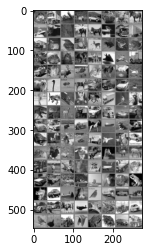

In [6]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get only the total amount of data that I wnat to work with here. 
dataiter = iter(trainloader)
keys, labels = dataiter.next()
nchannels = keys.shape[1]
# show images
imshow(torchvision.utils.make_grid(keys[:batch_size].view(batch_size, nchannels, image_len, image_len)))

cpu_keys = keys.flatten(start_dim=1)

trainloader = torch.utils.data.DataLoader(cpu_keys, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# L2 norm everything
keys = torch.clone(cpu_keys).to(device)
norm_keys = keys/torch.norm(keys, dim=1,keepdim=True)


In [23]:
if dataset=="MNIST":
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, transform=transform)
elif dataset=="CIFAR":
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

if m is None: 
    testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                          shuffle=False, num_workers=num_workers)
else: 
    testloader = torch.utils.data.DataLoader(testset, batch_size=m,
                                          shuffle=True, num_workers=num_workers)

dataiter = iter(testloader)
tkeys, labels = dataiter.next()
print(tkeys.shape)
# L2 norm everything
cpu_tkeys = tkeys.flatten(start_dim=1)

testloader = torch.utils.data.DataLoader(cpu_tkeys, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
tkeys = torch.clone(cpu_keys).to(device)

tnorm_keys = tkeys/torch.norm(tkeys, dim=1,keepdim=True)

print(testset)

torch.Size([10000, 1, 28, 28])
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


# Test many instances

In [10]:
import torch.nn.functional as F
from types import SimpleNamespace

train_params = dict(
    use_softmax = True,
    use_continuous = True, # if use softmax is off. 
    fix_perturb=False,
    proj_epochs = 10,#10,
    max_conv_steps = 100, # steps to update the query
    plot_batches = None, # plots losses during training more often
    plot_epochs = False,
    epsilon = 0.05, # removes any rounding error in computing the similarity.
    test_epsilon = 0.05,
    lr=0.01,
    check_for_closer_images = False,
    min_perturb = 10,
    max_perturb = 100,
    perturb=50,
    n=n,
    r=r,
    device=device,
    img_flat_len=img_flat_len,
    beta=None,
    cont_cache_resolution = 10000
)


sdm_params = dict(
    n=n, 
    r=n, 
    m=m, 
    h_dist=h_dist, 
    sdm_max_conv_steps=sdm_max_conv_steps, 
    image_len=image_len, 
    print_each_result=print_each_result
)

train_params = SimpleNamespace(**train_params)
sdm_params = SimpleNamespace(**sdm_params)

if m==1024:
    train_params.proj_epochs=100

In [11]:
cfracs = [0.000000001, 0.000368, 0.1]

hamm_iters = space_frac_to_hamm_dist(n,cfracs)
hamm_iters += [5,11,15] # also want 5,11,15
hamm_iters

[9, 19, 27, 5, 11, 15]

In [12]:
pert_dists = [0,50,100,150, 200, 250, 300]
neuron_vals = list(np.round(np.logspace(6,20,5))) #10
neuron_vals.append(None)
nrepeats = 3

load_in_W_k = True

In [ ]:
import copy
"""Iterate through hamming distances. For nrepeats train the projection matrix. Then iterate through the
 different methods to compare them. """

neuron_res_nrepeats = {k:[] for k in neuron_vals}
hamm_res_nrepeats = {k:copy.deepcopy(neuron_res_nrepeats) for k in hamm_iters}
all_res = {k:copy.deepcopy(hamm_res_nrepeats) for k in ['Binary', 'Continuous', 'Softmax']}

for h_param in hamm_iters:
    print('h_param is', h_param)
    sdm_params.h_dist = h_param
    # varying r doesnt matter for this beta fit. 
    beta = fit_beta(sdm_params.n, sdm_params.r, sdm_params.h_dist, plot=False,hard_mem_places = False)
    train_params.beta = beta

    for rep_ind in range(nrepeats):
        # reset W_k!
        W_k = torch.randn((n,img_flat_len), requires_grad=True, device=device)
        # train model using softmax.
        train_params.use_softmax=True
        train_params.fix_perturb=False
        # fit a new W here 
        
        if load_in_W_k:
            if dataset == "MNIST" and m is None:
                W_k_name = 'trained_weights/trained_W_k'+dataset+'|'+str(h_param)+'|'+str(rep_ind)+'.torch'
            
            else: 
                W_k_name = 'trained_weights/trained_W_k'+dataset+"|m="+str(m)+'|'+str(h_param)+'|'+str(rep_ind)+'.torch'
            W_k = torch.load(W_k_name).to(device)
        else: 
            W_k = train_projection(W_k, train_params, trainloader, keys, norm_keys)
            torch.save(W_k,'trained_weights/trained_W_k'+dataset+"|m="+str(m)+'|'+str(h_param)+'|'+str(rep_ind)+'.torch')

        # testing everything.
        train_params.fix_perturb=True
        for iter_key in all_res.keys():
            if iter_key =='Softmax':
                train_params.use_softmax=True
                pert_res, cos_res = test_projection(pert_dists, W_k, 
                                                    train_params, trainloader, 
                                                    testloader, keys, norm_keys,
                                                    tkeys, tnorm_keys, cached_intersects,
                                                    continuous_cached_intersects, plot_results=False )
                all_res[iter_key][h_param][neuron_vals[-1]].append((pert_res, cos_res))
                
            else: 
                if iter_key=='Binary':
                    train_params.use_softmax=False
                    train_params.use_continuous=False
                elif iter_key=='Continuous':
                    train_params.use_softmax=False
                    train_params.use_continuous=True
                else: 
                    raise Exception("iter params undefined.")
                
                # set the neuron value
                for r in neuron_vals:
                    train_params.r=r
                    #print('=======================',r)
                    # compute the caches
                    all_dvs = np.arange(0,n+1)
                    cached_intersects = expected_intersection_lune(n, all_dvs, h_param, r)
                    if r is not None and (iter_key=='Binary' and np.round(cached_intersects[0])==0.0):
                        print("r of", r, "is too small for d radii of", h_param, 'for:', iter_key, 
                              cached_intersects[:5])
                        continue
                    cached_intersects = torch.Tensor(cached_intersects).to(device)
                    cs_intervals = np.linspace(-1,1,train_params.cont_cache_resolution).astype(float)
                    cs_intervals[-1] = cs_intervals[-1] - 1e-15
                    continuous_cached_intersects = cap_intersection(n, cs_intervals, h_param, r, 
                                                                    ham_input=False, print_oobs=False)
                    if r is not None and (iter_key=='Continuous' and np.round(continuous_cached_intersects[-1])==0.0):
                        print(continuous_cached_intersects)
                        print("r of", r, "is too small for d radii of", h_param, 'for:', 
                              iter_key, continuous_cached_intersects[-5:])
                        continue
                    continuous_cached_intersects = torch.Tensor(continuous_cached_intersects.astype(float)).to(device)

                    pert_res, cos_res = test_projection(pert_dists, W_k, 
                                                train_params, trainloader, 
                                                testloader, keys, norm_keys,
                                                tkeys, tnorm_keys, cached_intersects,
                                                continuous_cached_intersects, plot_results=False )
                    all_res[iter_key][h_param][r].append((pert_res, cos_res))
                    
    
        with open(dataset+"|m="+str(m)+"gpu_hamm_dist_runs.pkl", 'wb') as fname: 
            pickle.dump(all_res, fname)

h_param is 9
r of 1000000.0 is too small for d radii of 9 for: Binary [0.00177111 0.00048808 0.00048808 0.0001688  0.0001688 ]


/home/trenton/SDM/SDM_Circ_Inter_Funcs.py:238: RuntimeWarning: divide by zero encountered in log
  expected_intersect = np.log(intersect)+np.log(perc_addresses_w_neurons)


In [33]:
all_res.keys()

dict_keys(['Binary', 'Continuous', 'Softmax'])

In [34]:
all_res['Binary'].keys()

dict_keys([9, 19, 27, 5, 11, 15])

In [17]:
all_res['Binary'][9].keys()
# neuron_vals

dict_keys([1000000.0, 3162277660.0, 10000000000000.0, 3.162277660168379e+16, 1e+20, None])

0 1.0 0.0


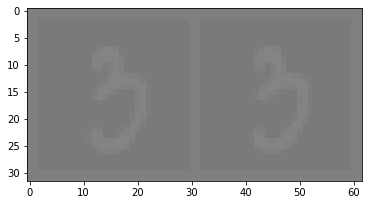

50 1.0 0.0


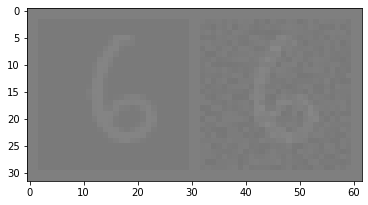

100 0.9908311224489796 0.008828288144394751


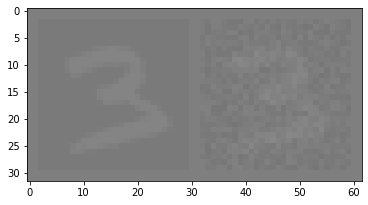

150 0.8759823554421767 0.007882055527289445


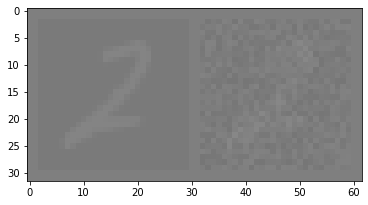

200 0.7972549319727891 0.007432570861612607


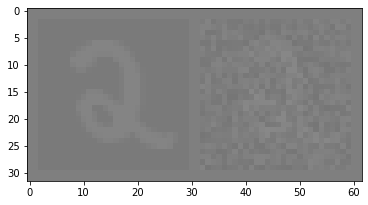

250 0.7384514668367347 0.008064297836186334


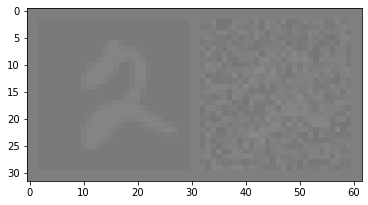

300 0.6908941113945577 0.008745175316834655


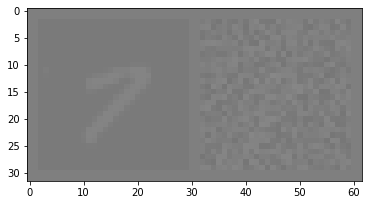

In [23]:
# baselines for the percentage reconstructed:
train_params.fix_perturb = True
num_to_display = 1
baseline_mus = []
for perturb in pert_dists:
    all_perc_recon = []
    train_params.perturb = perturb
    for batch_ind, queries in enumerate(trainloader): 
        queries = queries.to(device).T
        targets = torch.clone(queries)
        targets = targets/torch.norm(targets, dim=0,keepdim=True)

        queries, isclosests = perturb_queries(queries, train_params, norm_keys)

        #cs_dists = (queries/torch.norm(queries, dim=0,keepdim=True)*targets/torch.norm(targets, dim=0,keepdim=True)).sum(0)
        
        perc_recons =  torch.logical_and(targets-train_params.test_epsilon < queries , 
                                     targets+train_params.test_epsilon > queries).sum(0).cpu().detach().numpy() / train_params.img_flat_len  
      
        all_perc_recon += list(perc_recons)
    all_perc_recon = np.asarray(all_perc_recon)
    print(perturb, all_perc_recon.mean(), all_perc_recon.std())
    baseline_mus.append(all_perc_recon.mean())
    
    for i in range(num_to_display):
        ct = torch.cat( [targets[:,i].unsqueeze(0).cpu(), queries[:,i].unsqueeze(0).cpu()] )
        imshow(torchvision.utils.make_grid(ct.view(2, nchannels,image_len,image_len)))


In [13]:

load_all_res = True

if load_all_res:
    with open(dataset+"|m="+str(m)+"gpu_hamm_dist_runs.pkl", 'rb') as fname: 
        all_res = pickle.load(fname)

5 [0.99946696 0.9985608  0.96811867 0.7638889  0.5131353  0.36340368
 0.23478435]
9 [0.9990811  0.9983119  0.99503326 0.9719062  0.9147199  0.84732544
 0.80104035]
11 [0.9948747  0.9907732  0.9881487  0.9809352  0.9564182  0.909026
 0.85964924]
15 [0.96011305 0.95644385 0.9537173  0.9490673  0.940732   0.92361885
 0.89141494]
19 [0.9327159  0.93123484 0.92913157 0.92572874 0.9197313  0.908315
 0.88669884]
27 [0.88187665 0.8813081  0.8804753  0.87916005 0.8769421  0.87288845
 0.86523396]


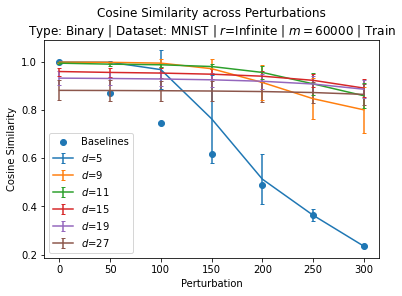

5 [0.9999156  0.9996414  0.9963827  0.96742725 0.85563594 0.65863657
 0.4653205 ]
9 [0.9996587  0.999347   0.99682933 0.9739779  0.91751426 0.84970975
 0.8084456 ]
11 [0.99822116 0.9973229  0.9959549  0.9906395  0.96401036 0.9102753
 0.85531217]
15 [0.96739477 0.9627835  0.95919096 0.9541314  0.9452421  0.9270703
 0.8924399 ]
19 [0.9357705  0.9342685  0.9321547  0.9287505  0.9227072  0.91097736
 0.888105  ]
27 [0.8842766  0.8836767  0.8827851  0.88137585 0.8790048  0.8746831
 0.8664109 ]


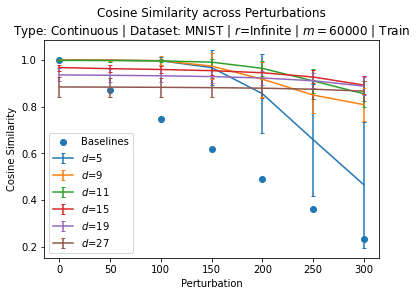

5 [0.99960506 0.9992148  0.9965214  0.97558403 0.9319619  0.88288957
 0.8451025 ]
9 [0.9991278  0.99854046 0.9814641  0.9388874  0.89616287 0.8684047
 0.8509762 ]
11 [0.99398065 0.99154377 0.9759257  0.9473821  0.91372776 0.884381
 0.8623075 ]
15 [0.9536276  0.9499229  0.94464904 0.9367172  0.9242464  0.90518767
 0.87988865]
19 [0.9269022  0.9250599  0.9223075  0.91801804 0.9109553  0.8990801
 0.88002515]
27 [0.8768122  0.8763321  0.8756112  0.8744725  0.8725262  0.86905617
 0.86247283]


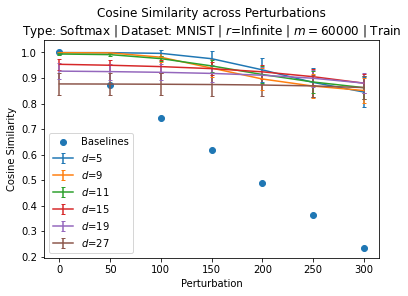

5 [0.96495324 0.9540812  0.85952884 0.6622652  0.49711418 0.36298773
 0.23477082]
9 [0.96916854 0.9650972  0.9555037  0.9294937  0.885604   0.8383959
 0.79945743]
11 [0.9699179  0.96776706 0.964153   0.9567154  0.9378082  0.9013977
 0.85828197]
15 [0.955188   0.9536668  0.9513612  0.9473481  0.9397274  0.9232842
 0.89164984]
19 [0.9328118  0.93146354 0.9293904  0.9260541  0.92013144 0.9087187
 0.8869991 ]
27 [0.8820703  0.88152194 0.88069034 0.8793791  0.87720436 0.8731509
 0.8654286 ]


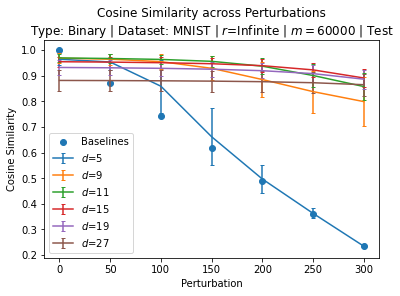

5 [0.945758   0.9397251  0.9314694  0.90302354 0.80995923 0.6463691
 0.46674973]
9 [0.961115   0.9595403  0.95144343 0.9255299  0.88359785 0.83992726
 0.8079926 ]
11 [0.9702633  0.96805996 0.96438015 0.9569108  0.9373593  0.8982324
 0.853453  ]
15 [0.95842946 0.9569123  0.9546368  0.9507507  0.94316417 0.92635274
 0.89228153]
19 [0.9357172  0.93438715 0.9323495  0.9290273  0.9230651  0.911351
 0.8886822 ]
27 [0.8844992  0.88391143 0.88302577 0.8816323  0.8792934  0.87495667
 0.8666689 ]


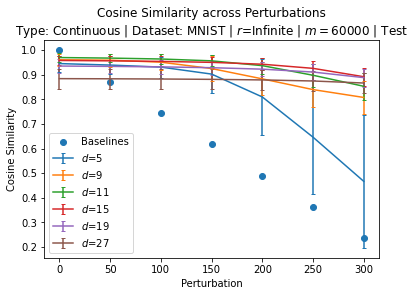

5 [0.9653481  0.96413827 0.95816064 0.9433739  0.9154322  0.8790539
 0.8444604 ]
9 [0.96795857 0.9601087  0.94246113 0.9157123  0.8884256  0.866969
 0.8505257 ]
11 [0.9656585  0.9598269  0.94948477 0.9320367  0.9080058  0.8830985
 0.8618536 ]
15 [0.94974923 0.94687384 0.9424843  0.9354251  0.92380285 0.9053644
 0.88006186]
19 [0.92698973 0.925198   0.92249507 0.91830534 0.9112843  0.8993535
 0.88031197]
27 [0.87690234 0.87642705 0.87570643 0.87457806 0.87265027 0.8691365
 0.8625289 ]


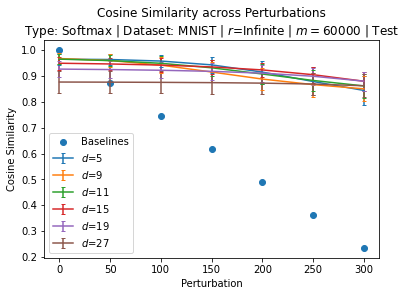

In [16]:
directory='figures/LearnProjections/'
baselines = hamm_to_cosine(np.asarray(pert_dists), n)

nneurons = None
use_cos_sim = True

for train in [True, False]:
    for key, res_per_key in all_res.items():
        # each is a dictionary i need to homogenize. 
        for h_param in np.sort(hamm_iters):

            agg = []

            for res in res_per_key[h_param][nneurons]:
                if train: 
                    agg.append(res[int(use_cos_sim)]['train'])
                    labl = 'Train'
                else: 
                    agg.append(res[int(use_cos_sim)]['test'])
                    labl='Test'
            agg = np.asarray(agg)

            iters_mu = agg.mean(axis=(0,2)) # mean for each iteration value
            iters_std = agg.std(axis=(0,2))

            #stds = np.stack([np.asarray(stds), np.zeros((len(stds)))])
            print(h_param, iters_mu)
            plt.errorbar(pert_dists, iters_mu, yerr=iters_std,capsize=2, label='$d$='+str(h_param))
        if use_cos_sim: 
            plt.scatter(pert_dists, hamm_to_cosine(np.asarray(pert_dists),img_flat_len), label='Baselines')
            prefix='Cosine Similarity'
        else: 
            plt.scatter(pert_dists, baseline_mus, label='Baselines')
            prefix='Percentage Reconstructed'
        
        if nneurons is None or nneurons == "None": 
            neuron_label = 'Infinite'
        else:
            print(float(nneurons))
            neuron_label = '$r$='+"{:.0e}".format(nneurons)
            
        if m is None: 
            printm= len(trainset)
            
        plt.title(prefix+" across Perturbations"+"\n"+"Type: "+key+" | Dataset: "+dataset+" | $r$="+neuron_label+" | $m=$"+str(printm)+" | "+labl)
        plt.legend()
        plt.xlabel("Perturbation")
        plt.ylabel(prefix)
        save_str = "Dataset="+dataset+"|UseCosSim"+str(use_cos_sim)+"|n="+str(n)+"m="+str(m)+"r="+str(r)+"Type="+key+"|NumNeuron="+neuron_label+"|"+labl
        plt.gcf().savefig(directory+save_str+'.png', dpi=250)
        plt.show()


skipping 5 1000000.0
skipping 5 3162277660.0
5 10000000000000.0 [0.9998537  0.965865   0.8834062  0.73951346 0.6198372  0.5135841
 0.41429585]
10000000000000.0
5 3.162277660168379e+16 [0.9999523  0.99974513 0.9990873  0.9894654  0.9415142  0.7860698
 0.52001846]
3.162277660168379e+16
5 1e+20 [0.9999523  0.99974865 0.9995303  0.9945899  0.9660475  0.85596055
 0.5915094 ]
1e+20
5 None [0.9999522  0.99974513 0.9995448  0.9945273  0.96622366 0.8565148
 0.5910924 ]


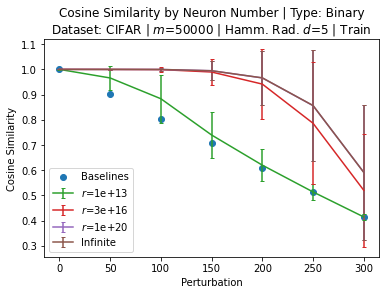

skipping 9 1000000.0
9 3162277660.0 [0.99960315 0.9961608  0.9576291  0.8407857  0.694394   0.5473379
 0.42383438]
3162277660.0
9 10000000000000.0 [0.99989676 0.99963397 0.9996005  0.9991122  0.99625707 0.9788489
 0.90189636]
10000000000000.0
9 3.162277660168379e+16 [0.9998969  0.9996376  0.99960303 0.99919397 0.9972067  0.98731554
 0.94152206]
3.162277660168379e+16
9 1e+20 [0.9883825  0.9911851  0.9937296  0.9957506  0.9957046  0.98699415
 0.9415538 ]
1e+20
9 None [0.9998969  0.99963886 0.9995993  0.99918157 0.9972803  0.98735195
 0.9413107 ]


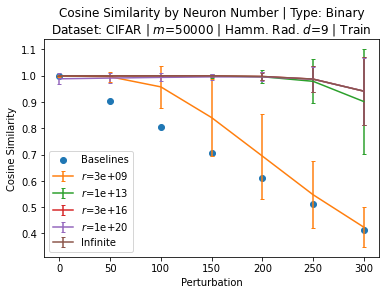

skipping 11 1000000.0
11 3162277660.0 [0.9997744  0.9991922  0.99874955 0.99610335 0.9822626  0.92490053
 0.7567205 ]
3162277660.0
11 10000000000000.0 [0.9998048  0.9994079  0.99928695 0.9987222  0.997111   0.99096906
 0.9655276 ]
10000000000000.0
11 3.162277660168379e+16 [0.99980456 0.9994075  0.9992896  0.99871105 0.99706656 0.9910011
 0.96579325]
3.162277660168379e+16
11 1e+20 [0.8783344  0.87786543 0.8775691  0.8770431  0.87634164 0.8750149
 0.8665244 ]
1e+20
11 None [0.9998049  0.99941105 0.9992837  0.9987348  0.99711925 0.99100834
 0.9656946 ]


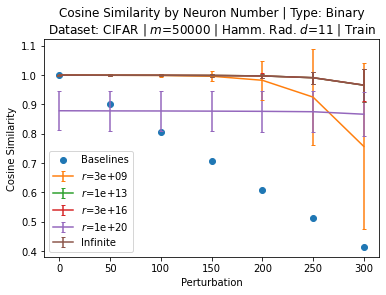

15 1000000.0 [0.8742688  0.8717159  0.84823596 0.8467271  0.8397647  0.8255905
 0.8062354 ]
1000000.0
15 3162277660.0 [0.87990105 0.8776252  0.8560138  0.85525614 0.8494592  0.83787477
 0.82293075]
3162277660.0
15 10000000000000.0 [0.87990105 0.8776131  0.8560693  0.8552469  0.8494647  0.83791196
 0.82283837]
10000000000000.0
15 3.162277660168379e+16 [0.8145745  0.81375515 0.81262434 0.81110984 0.8084707  0.8042129
 0.79634154]
3.162277660168379e+16
15 1e+20 [0.75629693 0.75531477 0.75393444 0.752076   0.74902356 0.7444837
 0.73655754]
1e+20
15 None [0.87990105 0.87765044 0.8560292  0.8552867  0.8495737  0.837883
 0.82286423]


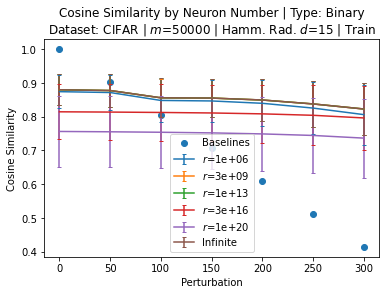

19 1000000.0 [0.7685593  0.76781774 0.76663893 0.76469177 0.76225305 0.7584501
 0.75201654]
1000000.0
19 3162277660.0 [0.76855934 0.7677952  0.76664317 0.7646223  0.76222    0.75852674
 0.7520264 ]
3162277660.0
19 10000000000000.0 [0.76672727 0.7660127  0.7649587  0.7635046  0.7613057  0.75771165
 0.75153863]
10000000000000.0
19 3.162277660168379e+16 [0.66715217 0.666448   0.6654386  0.66396004 0.661783   0.6582888
 0.6523209 ]
3.162277660168379e+16
19 1e+20 [0.6096024  0.6085662  0.6072056  0.6052416  0.60227495 0.59766614
 0.5894821 ]
1e+20
19 None [0.76855946 0.76781565 0.7666524  0.7646534  0.7621918  0.75859475
 0.75197655]


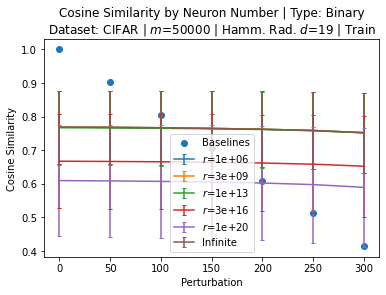

27 1000000.0 [0.642175   0.64178926 0.6412687  0.64048034 0.6393851  0.63743174
 0.6343579 ]
1000000.0
27 3162277660.0 [0.6421749  0.6418242  0.64126015 0.64050245 0.63931143 0.63752145
 0.6343374 ]
3162277660.0
27 10000000000000.0 [0.43173695 0.43107307 0.4301198  0.42876476 0.42677578 0.4233974
 0.41768706]
10000000000000.0
27 3.162277660168379e+16 [0.4083107  0.4075911  0.40659106 0.4050691  0.40307647 0.39955315
 0.3934148 ]
3.162277660168379e+16
27 1e+20 [0.40831053 0.407583   0.40657154 0.4052289  0.4029192  0.39944208
 0.39343897]
1e+20
27 None [0.6421751  0.64179987 0.64124715 0.6405012  0.63931125 0.63752556
 0.6341715 ]


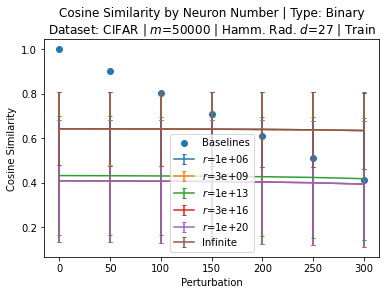

skipping 5 1000000.0
skipping 5 3162277660.0
skipping 5 10000000000000.0
skipping 5 3.162277660168379e+16
5 1e+20 [0.9999904  0.9979241  0.9520576  0.79140544 0.62390107 0.5127365
 0.4140664 ]
1e+20
5 None [0.9999904  0.99997133 0.9999284  0.99928397 0.9938971  0.9665053
 0.8652909 ]


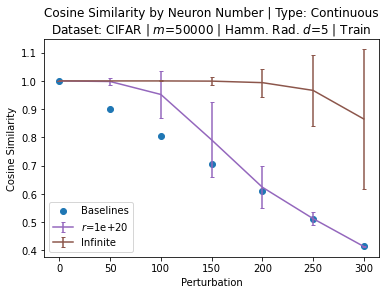

skipping 9 1000000.0
skipping 9 3162277660.0
9 10000000000000.0 [0.9999568  0.9998977  0.99847966 0.9816908  0.9084025  0.7143787
 0.4712844 ]
10000000000000.0
9 3.162277660168379e+16 [0.9999572  0.9999057  0.9998701  0.9996374  0.99725634 0.9804219
 0.90171945]
3.162277660168379e+16
9 1e+20 [0.9999349  0.99990624 0.99986976 0.99970794 0.99847376 0.99053055
 0.9495927 ]
1e+20
9 None [0.9999571  0.9999065  0.99986976 0.99971116 0.9984516  0.99053854
 0.94976187]


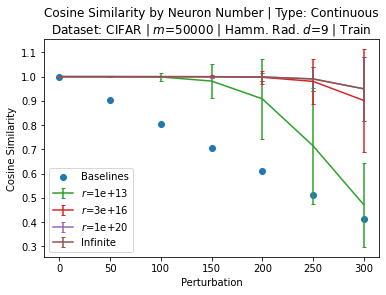

skipping 11 1000000.0
11 3162277660.0 [0.9998866  0.99955344 0.99296147 0.94848263 0.81430626 0.61113816
 0.44182807]
3162277660.0
11 10000000000000.0 [0.99992263 0.9998447  0.9997849  0.9996341  0.99877167 0.9924354
 0.9542537 ]
10000000000000.0
11 3.162277660168379e+16 [0.99992263 0.9998442  0.9997856  0.9996344  0.9989982  0.9955824
 0.9763109 ]
3.162277660168379e+16
11 1e+20 [0.99061656 0.9926473  0.99460137 0.996235   0.99713635 0.99469876
 0.9763592 ]
1e+20
11 None [0.99992263 0.9998446  0.9997897  0.9996468  0.99899405 0.99549073
 0.9761006 ]


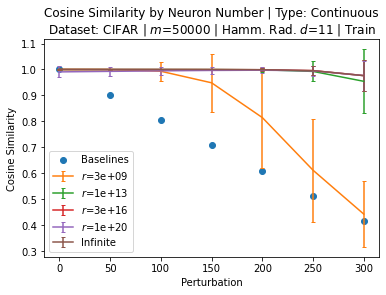

15 1000000.0 [0.9153725  0.89906114 0.8885652  0.876671   0.8612094  0.83830917
 0.7995751 ]
1000000.0
15 3162277660.0 [0.9252152  0.91184574 0.9039102  0.8954701  0.8851715  0.871192
 0.8503853 ]
3162277660.0
15 10000000000000.0 [0.9252156  0.91180533 0.9038959  0.8954678  0.88517636 0.87123615
 0.8504558 ]
10000000000000.0
15 3.162277660168379e+16 [0.8242194  0.8234573  0.82236654 0.82076055 0.8182541  0.81410927
 0.8063471 ]
3.162277660168379e+16
15 1e+20 [0.7683201  0.7674441  0.76618147 0.7643524  0.7616808  0.7573654
 0.7497059 ]
1e+20
15 None [0.9252156  0.91183907 0.9038924  0.8954146  0.8850922  0.8711204
 0.8504619 ]


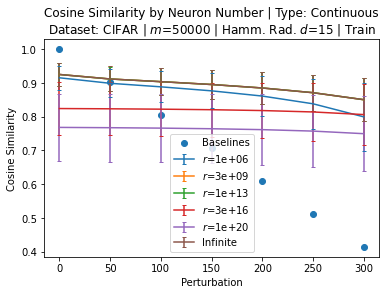

19 1000000.0 [0.7729688  0.7718255  0.77055055 0.7688664  0.76640016 0.7625468
 0.75580627]
1000000.0
19 3162277660.0 [0.7729689  0.7718325  0.7705394  0.76889    0.7663757  0.76245457
 0.7557603 ]
3162277660.0
19 10000000000000.0 [0.76865065 0.76795614 0.7669794  0.76554245 0.7634184  0.76000917
 0.75385016]
10000000000000.0
19 3.162277660168379e+16 [0.6703678  0.6696373  0.66862315 0.6672299  0.66516644 0.66159445
 0.65578663]
3.162277660168379e+16
19 1e+20 [0.5012053  0.4996598  0.49754485 0.49457678 0.4901677  0.48307416
 0.4714387 ]
1e+20
19 None [0.7729689 0.7718073 0.770576  0.7688488 0.7663409 0.7624548 0.7558069]


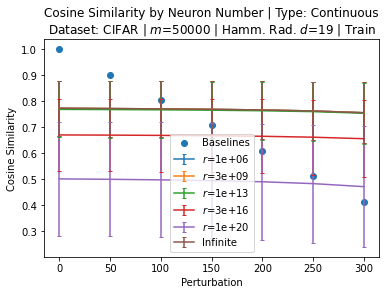

27 1000000.0 [0.6450181  0.6446284  0.64408505 0.6433092  0.64218265 0.6402723
 0.6370061 ]
1000000.0
27 3162277660.0 [0.6450181  0.6446197  0.6440551  0.643337   0.6421397  0.64035004
 0.6370902 ]
3162277660.0
27 10000000000000.0 [0.39878547 0.39804932 0.3970519  0.3956202  0.39340585 0.3898288
 0.38362396]
10000000000000.0
27 3.162277660168379e+16 [0.26704457 0.26615563 0.26496196 0.2632298  0.26051974 0.25639284
 0.249293  ]
3.162277660168379e+16
27 1e+20 [0.22122847 0.2203818  0.21919602 0.21765783 0.21517833 0.21129647
 0.20482413]
1e+20
27 None [0.6450181  0.6446044  0.6440835  0.6432379  0.64215857 0.64021945
 0.6370561 ]


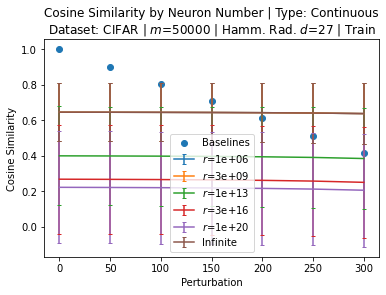

skipping 5 1000000.0
skipping 5 3162277660.0
skipping 5 10000000000000.0
skipping 5 3.162277660168379e+16
skipping 5 1e+20
5 None [0.9999486  0.9999296  0.99982727 0.99899125 0.9937842  0.9691259
 0.8856664 ]


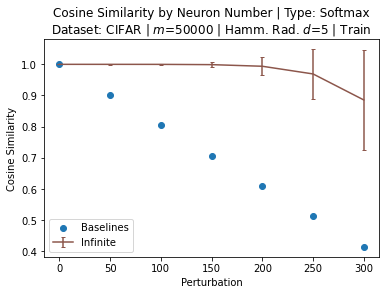

skipping 9 1000000.0
skipping 9 3162277660.0
skipping 9 10000000000000.0
skipping 9 3.162277660168379e+16
skipping 9 1e+20
9 None [0.9998576  0.9997875  0.99947065 0.9979798  0.9914004  0.9659245
 0.8868989 ]


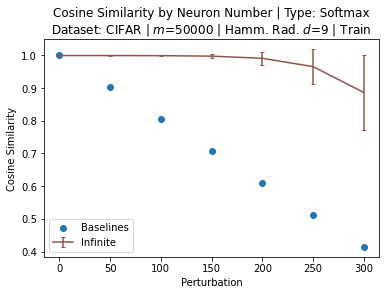

skipping 11 1000000.0
skipping 11 3162277660.0
skipping 11 10000000000000.0
skipping 11 3.162277660168379e+16
skipping 11 1e+20
11 None [0.9996175  0.9992507  0.9980647  0.9942322  0.9826102  0.94992125
 0.8722134 ]


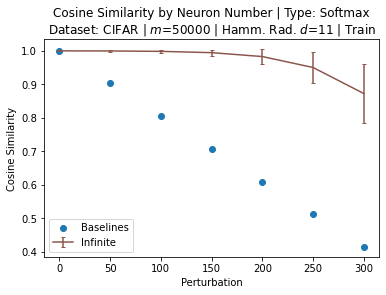

skipping 15 1000000.0
skipping 15 3162277660.0
skipping 15 10000000000000.0
skipping 15 3.162277660168379e+16
skipping 15 1e+20
15 None [0.8502828  0.8462845  0.84116083 0.83437574 0.8251768  0.81258607
 0.79460263]


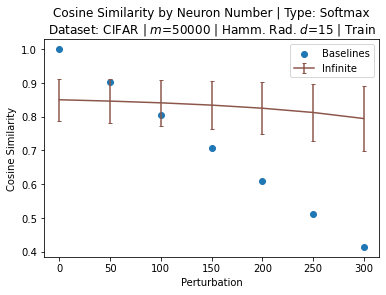

skipping 19 1000000.0
skipping 19 3162277660.0
skipping 19 10000000000000.0
skipping 19 3.162277660168379e+16
skipping 19 1e+20
19 None [0.76365477 0.76277596 0.76162386 0.7598879  0.7573616  0.7532395
 0.74630314]


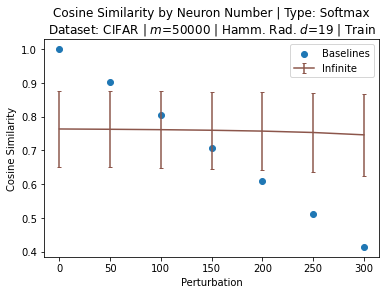

skipping 27 1000000.0
skipping 27 3162277660.0
skipping 27 10000000000000.0
skipping 27 3.162277660168379e+16
skipping 27 1e+20
27 None [0.635985   0.6355826  0.63507086 0.63425934 0.6330534  0.63108605
 0.6278411 ]


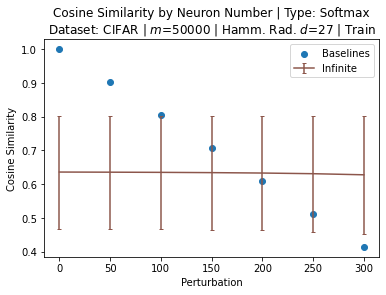

In [44]:
# varying the number of neurons: 
cmap = plt.get_cmap("tab10")

for train in [True]:
    for key, res_per_key in all_res.items():
        # each is a dictionary i need to homogenize. 
        for h_param in np.sort(hamm_iters):
            for nind, nneurons in enumerate(neuron_vals):
                
                if len(res_per_key[h_param][nneurons])==0:
                        print("skipping", h_param, nneurons)
                        continue
                agg = []
                for res in res_per_key[h_param][nneurons]:
                    if train: 
                        agg.append(res[int(use_cos_sim)]['train'])
                        labl = 'Train'
                    else: 
                        agg.append(res[int(use_cos_sim)]['test'])
                        labl='Test'
                        
                agg = np.asarray(agg)

                iters_mu = agg.mean(axis=(0,2)) # mean for each iteration value
                iters_std = agg.std(axis=(0,2))

                #stds = np.stack([np.asarray(stds), np.zeros((len(stds)))])
                print(h_param, nneurons, iters_mu)
                if nneurons is None or nneurons == "None": 
                    neuron_label = 'Infinite'
                else:
                    print(float(nneurons))
                    neuron_label = '$r$='+"{:.0e}".format(nneurons)
                plt.errorbar(pert_dists, iters_mu, color=cmap(nind), yerr=iters_std,capsize=2, label=neuron_label)
            if use_cos_sim: 
                plt.scatter(pert_dists, hamm_to_cosine(np.asarray(pert_dists),img_flat_len), label='Baselines')
                prefix='Cosine Similarity'
            else: 
                plt.scatter(pert_dists, baseline_mus, label='Baselines')
                prefix='Percentage Reconstructed'

            plt.title(prefix+" by Neuron Number"+" | Type: "+key+"\nDataset: "+dataset+" | $m$="+str(printm)+" | Hamm. Rad. $d$="+str(h_param)+" | "+labl)
            plt.legend()
            plt.xlabel("Perturbation")
            plt.ylabel(prefix)
            save_str = "NNeurons_Dataset="+dataset+"|UseCosSim"+str(use_cos_sim)+"|n="+str(n)+"m="+str(m)+"r="+str(r)+"Type="+key+"|NumNeuron="+neuron_label+"|d="+str(h_param)+"|"+labl
            plt.gcf().savefig(directory+save_str+'.png', dpi=250)
            plt.show()


# Generating example perturbation Figures

In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# baselines for the percentage reconstructed:
train_params.fix_perturb = True

for batch_ind, queries in enumerate(trainloader): 
    queries = queries.to(device).T
    targets = torch.clone(queries)
    targets = targets/torch.norm(targets, dim=0,keepdim=True)
    break 
        

print(hamm_to_cosine(np.asarray(pert_dists),img_flat_len))
i=0
all_p_queries = targets[:,i].unsqueeze(0).cpu()
for i in range(5):
    if i!=0:
        all_p_queries = torch.cat( [all_p_queries, targets[:,i].unsqueeze(0).cpu()])
    for perturb in pert_dists:
        if perturb==0.0:
            continue
        all_perc_recon = []
        train_params.perturb = perturb

        pqueries, isclosests = perturb_queries(queries, train_params, norm_keys)
        #cs_dists = (pqueries/torch.norm(pqueries, dim=0,keepdim=True)*targets/torch.norm(targets, dim=0,keepdim=True)).sum(0)
        #print(cs_dists[i])

        all_p_queries = torch.cat( [all_p_queries, pqueries[:,i].unsqueeze(0).cpu()])

[1.         0.90234375 0.8046875  0.70703125 0.609375   0.51171875
 0.4140625 ]


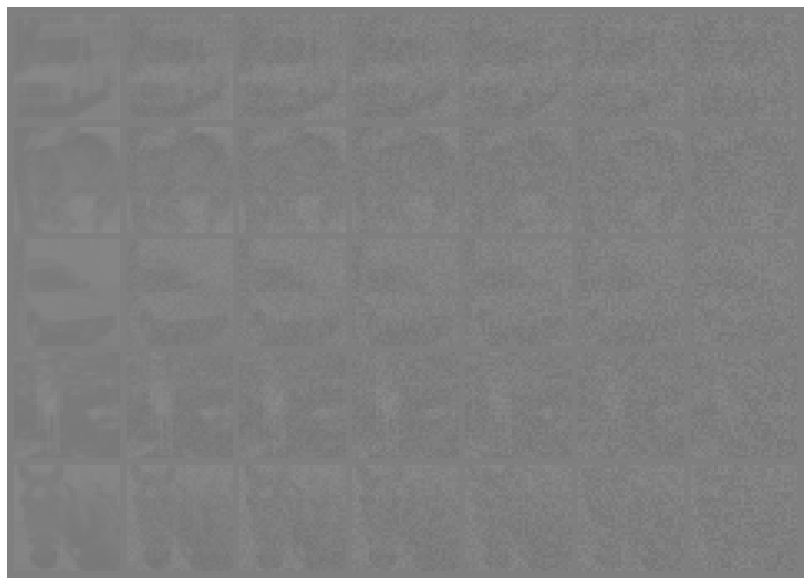

In [15]:
#ct = torch.cat( [targets[:,i].unsqueeze(0).cpu(), all_p_queries] )

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
imshow(torchvision.utils.make_grid(all_p_queries.view(all_p_queries.shape[0], nchannels,image_len,image_len),nrow=7),
          )
fig.savefig('figures/'+dataset+'Perturbs.png', dpi=100)
plt.show()

## Misc. evaluation of the images learnt, not used in the paper.

torch.Size([128, 784])
perc recon 0.9272959183673469
num agree spots 727 784


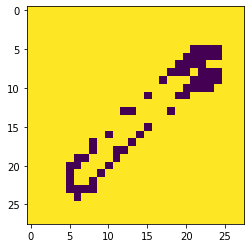

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


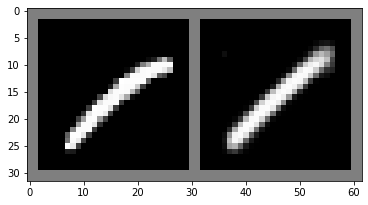

perc recon 0.9987244897959183
num agree spots 783 784


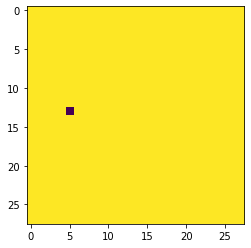

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


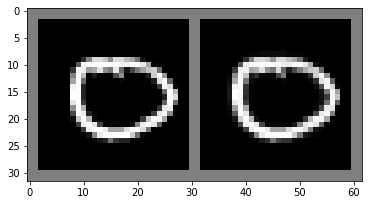

perc recon 1.0
num agree spots 784 784


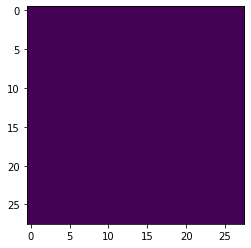

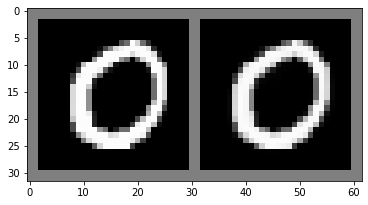

perc recon 1.0
num agree spots 784 784


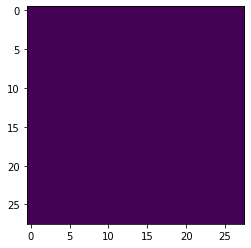

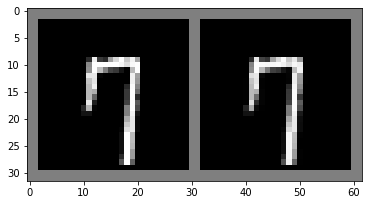

perc recon 0.9553571428571429
num agree spots 749 784


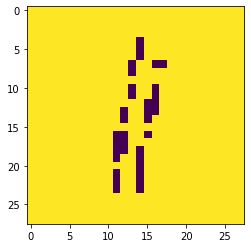

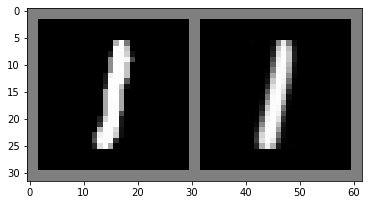

perc recon 1.0
num agree spots 784 784


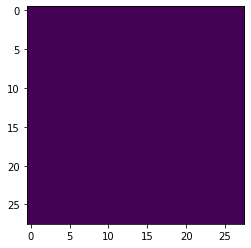

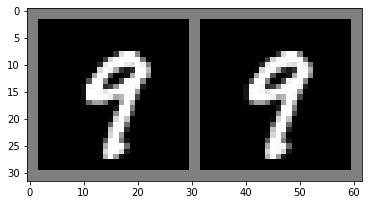

perc recon 0.9961734693877551
num agree spots 781 784


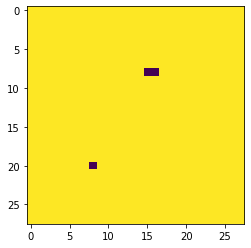

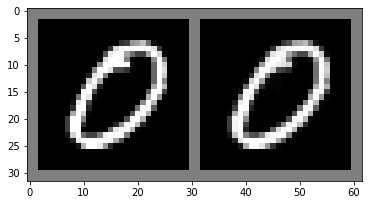

In [38]:
epsilon = 0.05
test_epsilon = 0.2 # debatable what this value should be. 
n_to_plot = 5
use_softmax=False
use_continuous = True
fix_perturb=False
check_for_closer_images = False
with torch.no_grad():
    for batch_ind, queries in enumerate(trainloader): 
        # get a minibatch
        bs = len(queries)
        print(queries.shape)
        queries = queries.to(device).T # making the queries into columns. 
        targets = torch.clone(queries)
        #project keys
        pKs = W_k@keys.T
        pKs = pKs/torch.norm(pKs, dim=0,keepdim=True)

        queries, isclosests, nsteps = convergence_loop(queries, norm_keys, keys)
        #print('nsteps', nsteps)
        # reconstruction loss after convergence iterations. 
        loss = ((queries - targets)**2).sum()

        perc_recon =  torch.logical_and(targets-test_epsilon < queries , 
                                 targets+test_epsilon > queries).sum(0).cpu().detach().numpy() / img_flat_len  

        agree_spots =torch.logical_and(targets-test_epsilon < queries , 
                                     targets+test_epsilon > queries).cpu().detach().numpy()

        for ind in range(bs):

            query, target, agree_spot = queries[:, ind].cpu().detach(), targets[:,ind].cpu().detach(), agree_spots[:,ind]

            plt.imshow(agree_spot.reshape(image_len,image_len))
            print( "perc recon", perc_recon[ind] )
            print( 'num agree spots', agree_spot.sum(), img_flat_len)
            plt.show()

            ct = torch.cat( [target.unsqueeze(0), query.unsqueeze(0)] )
            imshow(torchvision.utils.make_grid(ct.view(2, nchannels,image_len,image_len)))

            #imshow(target.detach().view(nchannels,image_len,image_len))
            #imshow(query.detach().view(nchannels,image_len,image_len))

            print("===========")
            if ind> n_to_plot:
                break
        break

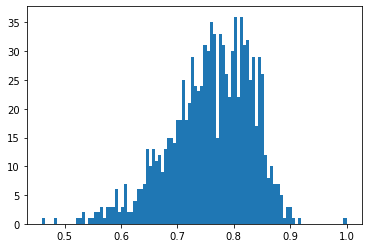

In [47]:
plt.hist((norm_keys@query/torch.norm(query)).detach().numpy(), bins=100)
plt.show()

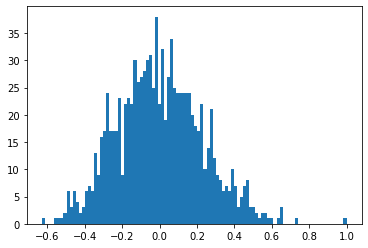

In [48]:

pQ = W_k@query
# L2 norm all
pQ = pQ/torch.norm(pQ)
# columnwise cosine similarities
dotp = pKs.T@pQ

plt.hist(dotp.detach().numpy(), bins=100)
plt.show()

In [49]:
tp=torch.cat((target.unsqueeze(0),query.unsqueeze(0)))

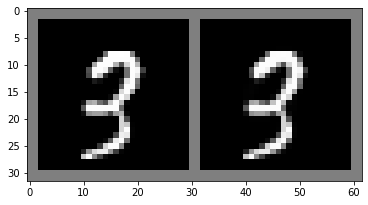

In [50]:
imshow(torchvision.utils.make_grid(tp.view(2, nchannels, image_len, image_len).detach() ))

In [51]:
((query - target)**2).sum()

tensor(0.0261, grad_fn=<SumBackward0>)

In [52]:
target.detach().view(nchannels,image_len, image_len);

In [53]:
query.detach().view(nchannels,image_len, image_len);

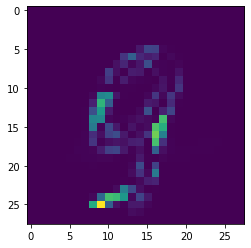

In [54]:
imshow(((query - target)**2).detach().view(nchannels,image_len, image_len))

In [27]:
torch.max(norm_keys@queries, dim=0)

torch.return_types.max(
values=tensor([0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449,
        0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449,
        0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449,
        0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449,
        0.7449, 0.7457, 0.7449, 0.7449]),
indices=tensor([33759, 49002,  2947,  1841, 42034, 12166, 57663, 31333, 22203, 43756,
        45599, 30029, 44815, 28322,  5055, 11904, 44425, 26443,  5319, 45482,
        23004, 14675, 55897, 36769, 10434, 46374,  2647, 49256, 30487, 16322,
        43495, 24735, 14097,  6621,  6352,  8941, 18521, 38965,  9210, 20521]))

torch.Size([10000, 1, 28, 28])
